# Más sobre evaluación de modelos y selección de features (segunda parte)

En este segundo notebook vamos a ver otra forma distinta (y más usada) de estimar la performance de modelos en vez del *train-test split*.

Seguimos trabajando con los datos de INTA, así que repetimos el proceso para cargarlos.

In [ ]:
# Como siempre, tratamos de traer todos los paquetes al ppio
from google.colab import drive # Para montar nuestro drive en la consola
import matplotlib.pylab as plt # Para gráficos
import numpy as np # Para manejo de arrays, operaciones matemáticas, etc.
from sklearn.linear_model import LogisticRegression # El método de regresión logística que vamos a usar
import pandas as pd # Para manejo de base de datos

# Traemos los datos
drive.mount('/content/drive') # Montamos nuestra unidad de Google Drive

filename = '/content/drive/My Drive/LaboDatos2021/datosDiariosSanFernandoINTA.xls'

d = pd.read_excel(filename) # Levantamos los datos, en este caso, con el método pd.read_excel

Mounted at /content/drive


Luego, filtramos el dataframe descartando columnas con datos faltantes, seleccionamos un subconjunto de columnas, y las renombramos.

In [ ]:
d_filtrado = d[['Temperatura_Abrigo_150cm_Maxima',
                'Temperatura_Abrigo_150cm_Minima',
                'Precipitacion_Pluviometrica',
                'Velocidad_Viento_Maxima',
                'Rocio_Medio',
                'Humedad_Media', 'Tesion_Vapor_Media']].dropna().copy() # Nos quedamos con ciertos campos del data set, para facilitar el trabajo. Y para limitarlo.
                                                  # Notar que primero aplicamos el método .dropna() para eliminar filas que tengan alguna columna con NaN 
                                                  # Ademas, el metodo copy() nos asegura que estemos creando un nuevo dataframe 
d_filtrado.rename({'Temperatura_Abrigo_150cm_Maxima' : 'temperaturaMaxima',
                   'Temperatura_Abrigo_150cm_Minima' : 'temperaturaMinima',
                   'Precipitacion_Pluviometrica' : 'precipitacion',
                   'Humedad_Media' : 'humedad',
                   'Rocio_Medio' : 'rocio',
                   'Velocidad_Viento_Maxima' : 'viento', 'Tesion_Vapor_Media': 'vapor'},
                  axis = 1,
                  inplace = True) # Esto toma como input un diccionario en el cual las llaves son los nombres actuales de columnas, y los valores los nombres nuevos (a los que queremos renombrar)
                                  # axis = 1 es porque queremos renombrar columnas, y inplace=True es porque queremos "pisar" el dataframe al renombrarlo

Finalmente, construimos una variable con las etiquetas de los días lluviosos.


In [ ]:
d_filtrado['llueveNollueve'] = 0 # empezamos con una columna llena de 0. 
indice =  d_filtrado['precipitacion'] > 0  # esto me da los valores del indice para los cuales hay precipitacion mayor a 0
d_filtrado.loc[indice, 'llueveNollueve'] = 1 # entonces para esos valores del indice pongo 1, porque en el dia correspondiente, llovio

d_filtrado['llueveNollueve'].value_counts()

0    717
1    337
Name: llueveNollueve, dtype: int64

# Validación cruzada estratificada

Empecemos con un modelo que incorpora features elevadas al cuadrado, cubo., etc. para darle más flexibilidad al modelo. 

Calculemos el AUC y ploteemos la curva ROC para los datos de entrenamiento y de evaluación siguiendo un train-test split con 70-30.


AUC entrenamiento: 0.7698
AUC evaluacion: 0.6974


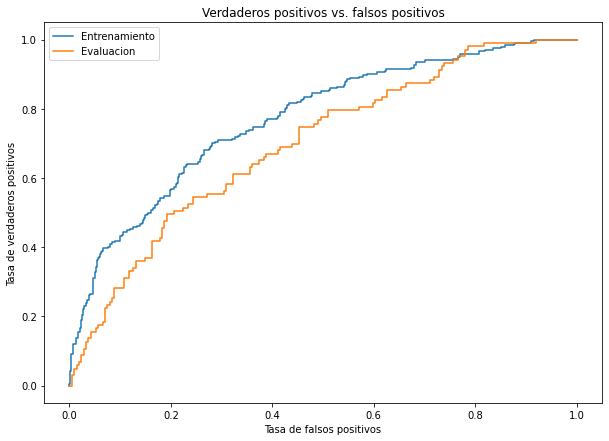

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Definamos la matriz X
campos = ['temperaturaMinima', 'temperaturaMaxima', 'humedad', 'rocio', 'vapor'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = d_filtrado['llueveNollueve'] # Nuestra etiqueta sigue siende la misma de antes

X_temp = X
for i in np.arange(2,6):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
X_1 = X_temp
 

X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.3) # armo el split

scaler = MinMaxScaler() # escaleo por separado ambos sets
scaler.fit(X_train) 
X_train = scaler.transform(X_train)

scaler = MinMaxScaler() # escaleo por separado ambos sets
scaler.fit(X_test) 
X_test = scaler.transform(X_test)

regLog_1 = LogisticRegression(penalty = 'none', max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

probas_train = regLog_1.predict_proba(X_train)  # probabilidades con datos de entrenamiento
probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, probas_train[:,1]) # para plotear curva ROC con datos de entrenamiento
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de evaluacion

auc_train = roc_auc_score(y_train, probas_train[:,1]) #  AUC con datos de entrenamiento
auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

# para plotear ROC (codigo de un notebook anterior)

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr_train,tpr_train, label = "Entrenamiento") # graficamos la curva ROC para el set de entrenamiento
ax.plot(fpr_test,tpr_test, label = "Evaluacion") # graficamos la curva ROC para el set de evaluacion

ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y

plt.legend()

print('AUC entrenamiento: {}'.format(round(auc_train,4)))  
print('AUC evaluacion: {}'.format(round(auc_test,4)))  



Podemos darle Play varias veces al bloque de código anterior. Vamos a ver que hay una variabilidad natural en las curvas, aunque en general el AUC de evaluacion será menor que el de entrenamiento, debido al overfitting.

**Un problema del train-test split es que depende mucho de qué casos fueron a parar a cada uno de los conjuntos.**

Si tuvimos "suerte" entonces los casos del conjunto de entrenamiento serán muy informativos y el clasificador tendrá buena performance. Pero sino, no. Entonces esto fluctúa dependiendo del azar.

Otro problema es que el train-test split produce predicciones no sesgadas por overfitting **únicamente para los casos que fueron al test set.** Si quisieramos una predicción del modelo para todos los casos, entonces para aquellos en el train set obtendríamos una predicción más certera de lo esperable realmente.

Una forma de atenuar estos problemas es usar **validación cruzada estratificada con K folds**, la cual funciona de la siguiente manera:

1.   Se dividen los datos en K subconjuntos de forma tal que la prevalencia de ambas clases esté balanceada en cada subconjunto.
2.   Se elige uno de esos subconjuntos y se lo designa set de evaluación. Todos los demás son sets de entrenamiento. Se entrena entonces al modelo usando estos datos para evaluación y entrenamiento, y se genera una predicción para cada uno de los datos en el conjunto que fue elegido como evaluación.
3.   Se repite el proceso usando cada uno de los K subconjuntos para evaluación exactamente una vez.

De esta forma, tenemos que todos los datos fueron usados una vez para evaluación y al menos una vez para entrenamiento. Además, tenemos una predicción para cada uno de los casos, y esta predicción no está afectada por overfitting (porque ese caso no fue usado en entrenamiento).

Veamos como funciona implementarlo en scikit-learn.



In [ ]:
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Definamos la matriz X
campos = ['temperaturaMinima', 'temperaturaMaxima', 'humedad', 'rocio', 'vapor'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = np.array(d_filtrado['llueveNollueve']) # Nuestra etiqueta sigue siende la misma de antes

X_temp = X
for i in np.arange(2,6):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
X_1 = X_temp
 

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X_1, y) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores

for train_index, test_index in skf.split(X_1, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X_1[train_index], X_1[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty = 'none', max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores = np.concatenate((scores,probas_test[:,1]),axis=0)
    indices = np.concatenate((indices,test_index),axis=0)

print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))
print("Estos son las probabilidades para cada sample:")
print(scores)
print("Esta es la forma en que quedaron ordenados las entradas del vector anterior (indices):")
print(indices)




Estos son los valores AUC para cada fold:
[0.7159605100781572, 0.809543397778692, 0.6983830845771144, 0.748134328358209, 0.7340569877883311]
Estos es el promedio de todos los AUC:
0.7412156617161008
Estos son las probabilidades para cada sample:
[0.17695431 0.19192147 0.22520072 ... 0.26286311 0.19942934 0.48323599]
Esta es la forma en que quedaron ordenados las entradas del vector anterior (indices):
[   4.    6.    8. ... 1039. 1041. 1052.]


Por último, también se puede seguir un esquema de validación tipo "leave one out" (dejar uno afuera). Esta estrategia da un mejor estimativo de la performance del clasificador sobre los datos, pero es más costoso computacionalmente. Supongamos que tenemos $N$ samples, entonces los dividimos en $N$ grupos de entrenamiento y validación, donde los conjuntos de validación tienen un solo elemento, que va siendo cada uno de los samples en mi dataset, y los conjuntos de entrenamiento tienen todos los samples menos el que quedó en el conjunto de evaluación. **Así, todos los datos posibles se usan para estimar la clase de cada sample en el dataset.**

```
# sklearn.model_selection.LeaveOneOut[source]¶
```



# Para llevarse de este notebook

*   El train-test split tiene la desventaja de que dependiendo del azar, algunos datos se usan para entrenar y otros para evaluar, y que no obtenemos una estimación no sesgada de todos los samples en el dataset, únicamente de ellos que fueron a parar al test set.
*   Esto se puede resolver usando la validación cruzada estratificada con K-folds:


```
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X_1, y) 
for train_index, test_index in skf.split(X_1, y):

```

Dentro del for loop (que se ejecuta tantas veces como folds fueron elegidos), las variables train_index y test_index van tomando los valores que corresponden a cada fold en el cual se intenta balancear las cantidad de ejemplos de cada clase.

*   Otra forma de hacer esto es con "leave one out", que es más costoso computacionalmente:

```
# sklearn.model_selection.LeaveOneOut[source]¶
```

pero que usa todos los datos posibles para estimar la etiqueta de cada sample.

